## Preliminary Experiments into First-Order $\tau$ Mismatch

Here we build a scalar communication channel, and give each neuron's encoding synapse a different first-order lowpass with $\tau_i$ drawn from a lognormal distribution (mean $\mu = 5\,ms$ and standard deviation $\sigma = 0.5$). We investigate two overlapping questions:

1. What is the error in assuming all synapses are first-order with $\tau = \mu$? How does this error scale with $\sigma$?
2. Is there a better (more useful / accurate) _model_ for the effect of this mismatch?

Assuming we can model (2) sufficiently well, we can analyze the error in (1) by comparing these two models. This may also lead to an improved method of solving for decoders given each $\tau_i$.

For (2) we propose modeling the effects using an $n^{th}$-order lowpass synapse, $H(s) = \frac{1}{n} \sum_{i=1}^{n} H_i(s)$, where $H_i(s) = \frac{1}{\tau_i s + 1}$ is the $i^{th}$ filter. This is known as a _residual_ or [partial fraction representation](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.invres.html) of a filter. This is the average of all the synapses (which is **not** the same as averaging the $\tau$). This essentially assumes that each neuron's decoder yields a perfect communication channel in isolation (divided by $n$).

As the number of neurons increases, this model should (?) approach the true behaviour. For smaller numbers of neurons, I don't know how good this model is in theory, since it depends on the decoders and the neural nonlinearity and the function being approximated. 

Note (2) is useful because we can use the _Generalized Principle 3_ for linear synapses of arbitrary order with this model, to either get a better estimate of the error, or to improve the recurrent decoders.

Below we do some preliminary numerical experiments, comparing models (1) and (2) to the actual communication channel with $\tau$ mismatch.

In [1]:
%pylab inline

import numpy as np
import scipy
import pylab

import nengo
import nengolib

Populating the interactive namespace from numpy and matplotlib


In [2]:
def embed(encoders, hetero_synapse):
    def inner(x, encoders=encoders, hetero_synapse=hetero_synapse):
        # See http://stackoverflow.com/questions/26168363/ for a more efficient solution.
        return np.sum(encoders * hetero_synapse.from_vector(x), axis=1)
    return inner
    
def nrmse(observed, expected):
    return nengo.utils.numpy.rmse(observed, expected) / nengo.utils.numpy.rms(expected)

def do_everything(
        n_neurons=100,
        tau_mean=0.005,
        tau_sigma=0.5,
        tau_probe=None,
        bandpass=50,
        neuron_type=nengo.LIFRate(),
        dt=0.0001,
        T=0.5,
        ens_seed=0,
        plot_taus=True,
        plot_sim=True):
    
    process = nengo.processes.WhiteSignal(T, high=bandpass, y0=0)
    taus = np.random.lognormal(mean=np.log(tau_mean), sigma=tau_sigma, size=n_neurons)
    synapses = [nengolib.Lowpass(tau) for tau in taus]

    hs = nengolib.synapses.HeteroSynapse(synapses, dt)
    encoders = nengolib.stats.sphere.sample(n_neurons, 1)

    if plot_taus:
        figure()
        hist(taus, bins=100, lw=0)
        pylab.title("Time-Constant Distribution")
        pylab.xlabel(r"$\tau$ (s)")
        pylab.ylabel("Count")
        show()

    with nengolib.Network() as model:
        stim = nengo.Node(size_in=1)
        nengo.Connection(nengo.Node(output=process), stim, synapse=None)

        syn = nengo.Node(size_in=1, output=hs)
        x_mismatch = nengo.Ensemble(n_neurons, 1, seed=ens_seed, encoders=encoders, neuron_type=neuron_type)
        x_standard = nengo.Ensemble(n_neurons, 1, seed=ens_seed, encoders=encoders, neuron_type=neuron_type)
        x_model = nengo.Ensemble(n_neurons, 1, seed=ens_seed, encoders=encoders, neuron_type=neuron_type)

        nengo.Connection(stim, syn, synapse=None)
        nengo.Connection(syn, x_mismatch.neurons, function=embed(encoders, hs), synapse=None)
        nengo.Connection(stim, x_standard, synapse=tau_mean)

        # both of these are numerically unstable unless n_neurons is really small...
        #model_synapse = nengolib.signal.LinearSystem(
        #    scipy.signal.invres(1.0 / taus / n_neurons, -1.0 / taus, []))
        #model_synapse = np.mean(synapses)
        #nengo.Connection(stim, x_model, synapse=model_synapse)
        for synapse in synapses:
            nengo.Connection(stim, x_model, transform=1.0 / n_neurons, synapse=synapse)

        p_mismatch = nengo.Probe(x_mismatch, synapse=tau_probe)
        p_standard = nengo.Probe(x_standard, synapse=tau_probe)
        p_model = nengo.Probe(x_model, synapse=tau_probe)

    with nengo.Simulator(model, dt=dt) as sim:
        sim.run(T, progress_bar=False)

    if plot_sim:
        figure()
        title("Simulation Results")
        plot(sim.trange(), sim.data[p_mismatch], label="Actual Mismatch")
        plot(sim.trange(), sim.data[p_standard], label="(1) Standard")
        plot(sim.trange(), sim.data[p_model], label="(2) Model")
        xlabel("Time (s)")
        legend()
        show()
        
    return (
        nrmse(sim.data[p_standard], sim.data[p_mismatch]),
        nrmse(sim.data[p_model], sim.data[p_mismatch]))

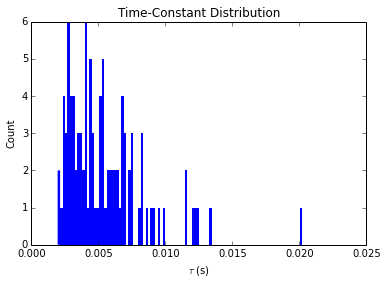

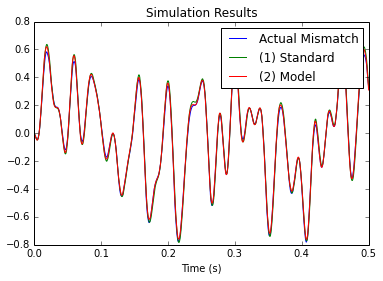

In [3]:
_ = do_everything(tau_sigma=0.5)

In [4]:
sigmas = np.linspace(1e-9, 1.0, 10)
errors = []

for sigma in sigmas:
    errors.append(do_everything(tau_sigma=sigma, plot_taus=False, plot_sim=False))

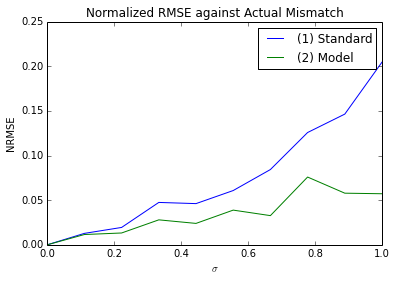

In [5]:
errors = np.asarray(errors)

figure()
title("Normalized RMSE against Actual Mismatch")
plot(sigmas, errors[:, 0], label="(1) Standard")
plot(sigmas, errors[:, 1], label="(2) Model")
xlabel(r"$\sigma$")
ylabel("NRMSE")
legend()
show()